# Data preparation

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [21]:
df = pd.read_csv("Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [22]:
df = df.rename(columns={"DATE":"date", "IPG2211A2N":"value",})
df["date"] = df['date'].astype("datetime64[ns]")
df.set_index('date', inplace=True)
df.tail()

,value
date,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


<Axes: xlabel='date'>

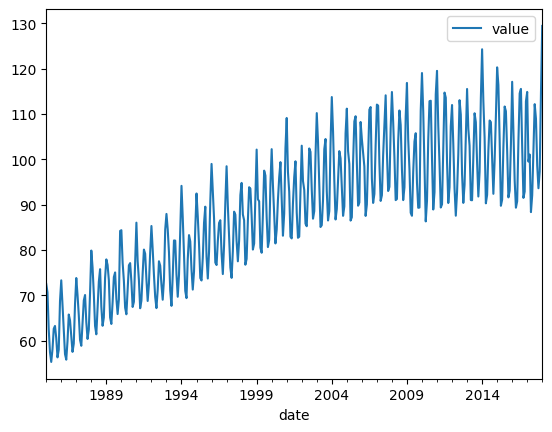

In [24]:
df.plot()

# Tensorflow LSTM RNN

In [25]:
prediction_window=12

n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

In [26]:
train = df.copy()
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

In [27]:
# Create sliding window dataset
def sliding_windows(data, n_input):
    X_train=[]
    Y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        Y_train.append(data[i])
    return np.array(X_train), np.array(Y_train)

In [28]:
x, y = sliding_windows(scaled_train, prediction_window)

In [29]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.23201741 0.20727443 0.09630353 0.02910391 0.         0.03745865
 0.09859805 0.10707831 0.07112325 0.0135012  0.03624525 0.18085375]
Predict this value: 
 [0.24282188]


In [30]:
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (385, 12, 1)
y shape: (385, 1)


In [31]:
train_size = int(len(train) - prediction_window*3)
# Train-validation split
x_train = x[:train_size]
y_train = y[:train_size]
x_valid = x[train_size:]
y_valid = y[train_size:]

# LSTM Modeling

In [32]:
def build_lstm_model(input_shape, hidden_size=32, output_size=1):
    #input layer
    inputs = Input(shape=input_shape)
    
    #lstm layer
    x = LSTM(hidden_size, return_sequences=False)(inputs)
    
    #dense layer
    x = Dense(40)(x)
    
    #relu activation
    x = ReLU()(x)
    
    #output layer
    outputs = Dense(output_size)(x)
    
    #create the model using the inputs and outputs
    model = Model(inputs, outputs)
    
    return model

input_shape = (n_input, n_features)  # Example: (12, 3)
model = build_lstm_model(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 40)                  │           1,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,713 (22.32 KB)

 Trainable params: 5,713 (22.32 KB)

 Non-trainable params: 0 (0.00 B)

# Compile the Model

In [33]:
EPOCHS = 500
initial_lr = 0.01

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# Train the Model

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=EPOCHS,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]  # Adding EarlyStopping
)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0793 - mae: 0.2148 - val_loss: 0.0625 - val_mae: 0.2043
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0202 - mae: 0.1171 - val_loss: 0.0328 - val_mae: 0.1390
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159 - mae: 0.1032 - val_loss: 0.0238 - val_mae: 0.1239
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0138 - mae: 0.0983 - val_loss: 0.0253 - val_mae: 0.1251
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0123 - mae: 0.0923 - val_loss: 0.0233 - val_mae: 0.1227
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0119 - mae: 0.0912 - val_loss: 0.0204 - val_mae: 0.1221
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0118 - mae: 0.0902 - val_loss: 0.0202 - val_mae: 0.1217
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0122 - mae: 0.0916 - val_loss: 0.0208 - val_mae: 0.1186
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - lo

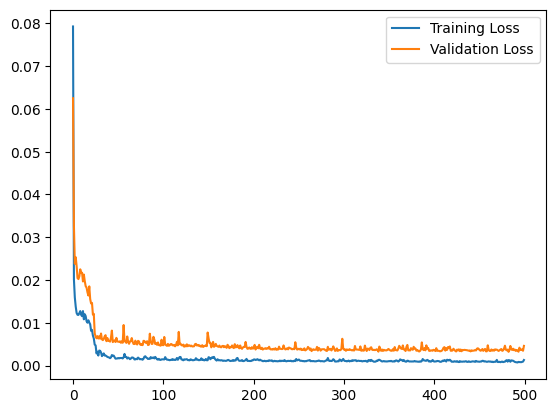

In [35]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

# Plot the Moving Average of Loss Curves

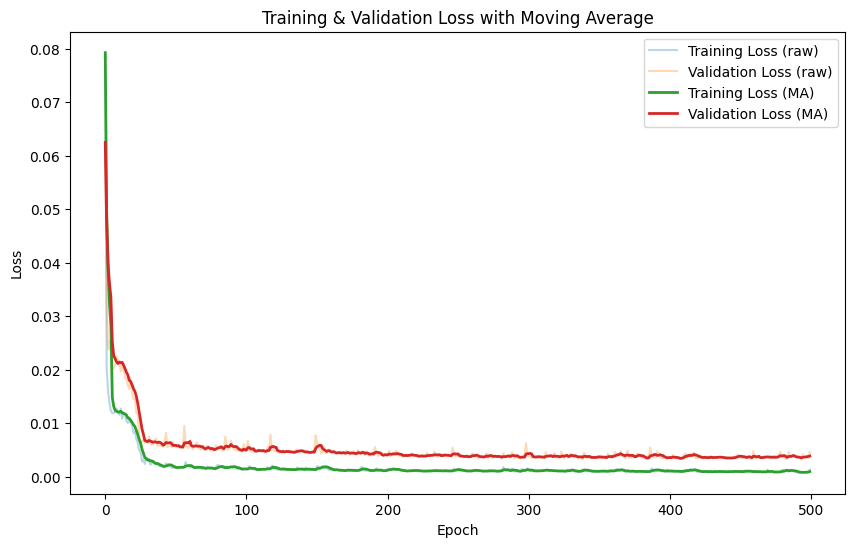

In [36]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Convert to pandas Series for rolling mean
train_loss_ma = pd.Series(train_loss).rolling(window=5, min_periods=1).mean()
val_loss_ma = pd.Series(val_loss).rolling(window=5, min_periods=1).mean()

# Plot original and moving average
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss (raw)', alpha=0.3)
plt.plot(val_loss, label='Validation Loss (raw)', alpha=0.3)
plt.plot(train_loss_ma, label='Training Loss (MA)', linewidth=2)
plt.plot(val_loss_ma, label='Validation Loss (MA)', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss with Moving Average')
plt.show()

# Save and Load the model

In [37]:
# Load the model
model = load_model('lstm_electric_production.keras')  # or .keras if you saved in the new format

# Predict and Compare Actual vs. Predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


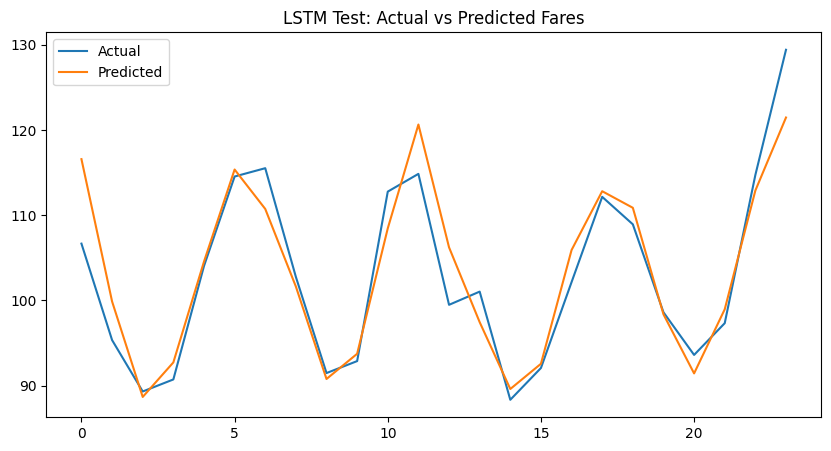

In [38]:
# Predict on validation set
y_pred_scaled = model.predict(x_valid)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_valid)

# Flatten if needed
y_pred = y_pred.flatten()
y_true = y_true.flatten()

# Visualize Results
plt.figure(figsize=(10,5))
plt.plot(y_true[-25:], label='Actual')
plt.plot(y_pred[-25:], label='Predicted')
plt.legend()
plt.title('LSTM Test: Actual vs Predicted Fares')
#plt.xlabel('Sample')
#plt.ylabel('Fare Amount')
plt.show()

# Metrics

In [39]:
# Create df_pred with last 24 entries from training data
df_pred = train.iloc[-24:].copy()
df_pred['prediction'] = y_pred  # Add the predictions to df_pred

In [41]:
# Define a function for MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for LSTM Model
mape_lstm = mape(df_pred["value"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 2.68 %


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"MAE OF LSTM MODEL: {mae:.2f}, RMSE OF LSTM MODEL: {rmse:.2f}")

MAE OF LSTM MODEL: 2.84, RMSE OF LSTM MODEL: 3.84


C:\Users\Nafisa Islam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# LSTM Forecasting

In [43]:
train.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [44]:
# --------- STEP 1: Get the last window from your training set ----------
last_window = scaled_train[-n_input:]                 # Shape: (n_input, n_features)
current_input = last_window.reshape(1, n_input, n_features)  # Reshape: (1, n_input, n_features); Machine learning models (like LSTM) expect a 3D input
# batch_size = 1 (we’re predicting one sequence at a time)

# --------- STEP 2: Make recursive (rolling) predictions ----------
forecast_steps = n_input   # Predict the next n_input steps
predictions = []

for step in range(forecast_steps):
    next_pred = model.predict(current_input)          # Predict next value, shape: (1, 1)
    predictions.append(next_pred[0, 0])              # Store scalar prediction
    
    # Update the input window: drop oldest, add new prediction
    next_pred_reshaped = next_pred.reshape(1, 1, n_features)
    current_input = np.concatenate([current_input[:, 1:, :], next_pred_reshaped], axis=1)

# --------- STEP 3: Convert predictions to original scale ----------
pred_array = np.array(predictions).reshape(-1, 1)
pred_rescaled = scaler.inverse_transform(pred_array).flatten()

# --------- STEP 4: Create DataFrame with forecasted dates ----------
date_offset = n_input
# Make sure train.index is a DatetimeIndex
forecast_dates = (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
df_forecast = pd.DataFrame({'prediction': pred_rescaled}, index=forecast_dates)

# --------- STEP 5: Concatenate previous predictions with forecast ----------
# (Assume df_pred contains previous actuals and predictions)
df_full = pd.concat([df_pred, df_forecast])

# --------- Optional: View result ----------
print(df_forecast.head(12))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
            prediction
date                  
2018-02-01  111.963951
2018-03-01  101.668365
2018-04-01   88.849564
2018-05-01   92.231644
2018-06-01  104.526588
2018-07-01  112.349380
2018-08-01  111.110741
2018-09-01   99.509605
2018-10-01   91.294617
2018-11-01   96.692223
2018-12-01  113.939171
2019-01-01  123.425262


In [45]:
df_full

,value,prediction
date,,
2016-02-01,106.6688,116.577560
2016-03-01,95.3548,99.883301
2016-04-01,89.3254,88.686150
2016-05-01,90.7369,92.735329
2016-06-01,104.0375,104.554649
2016-07-01,114.5397,115.359726
2016-08-01,115.5159,110.736732
2016-09-01,102.7637,101.632919
2016-10-01,91.4867,90.791245


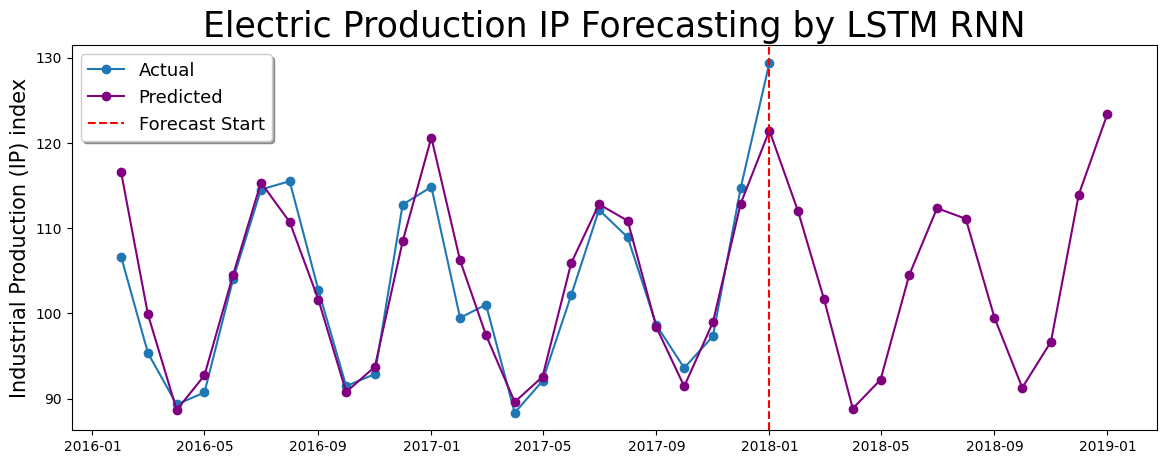

In [46]:
# Plotting the forecast results with Actual and Predicted values
plt.figure(figsize=(14, 5))

# Plot the actual values (df['value'])
plt.plot(df_full.index, df_full["value"], label="Actual", marker="o")

# Plot the predicted values (LSTM forecasted)
plt.plot(df_full.index, df_full["prediction"], label="Predicted", marker="o", color="purple")

# Add a vertical line to distinguish between actual data and forecasted data
plt.axvline(df_pred.index[-1], color="red", linestyle="--", label="Forecast Start")

# Title and labels
plt.title("Electric Production IP Forecasting by LSTM RNN", fontsize=25)
plt.ylabel('Industrial Production (IP) index', fontsize=15)

# Legend settings
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)

# Show the plot
plt.show()

# SARIMA modeling

<Figure size 1000x800 with 0 Axes>

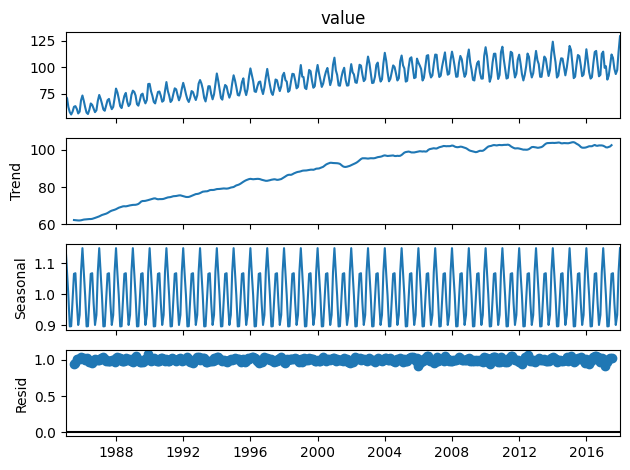

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
result = seasonal_decompose(df['value'], model='multiplicative', period=12)

# Plot the seasonal decomposition
fig = plt.figure(figsize=(10, 8))
fig = result.plot()
plt.show()

In [48]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on the time series
result = adfuller(df['value'].dropna())  # Dropping any NaN values

# Output the ADF test statistic and p-value
print(f'ADF Statistics: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics: -2.25699035004725
p-value: 0.18621469116586592


In [49]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the differenced series
result = adfuller(df['value'].diff().dropna())

# Output the ADF test statistic and p-value
print(f'ADF Statistics: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics: -7.104890882267312
p-value: 4.0777865655394095e-10


# ACF and PACF

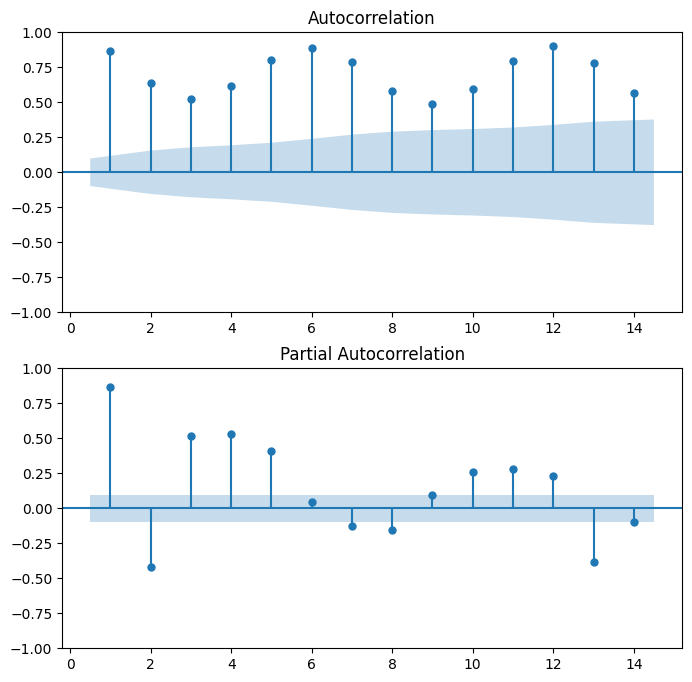

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# ACF plot (Autocorrelation Function)
plot_acf(df['value'], lags=14, zero=False, ax=ax1)

# PACF plot (Partial Autocorrelation Function)
plot_pacf(df['value'], lags=14, zero=False, ax=ax2)

# Display the plots
plt.show()

# Auto ARIMA

In [51]:
import pmdarima as pm

In [52]:
# Automatically find the best SARIMA model for your data
results = pm.auto_arima(
    df,                  # Your time series (e.g., pd.Series)
    d=1,                 # Differencing to remove trend
    start_p=1, max_p=3,  # AR terms to try
    start_q=1, max_q=3,  # MA terms to try
    seasonal=True,       
    m=6,                 # Season length (e.g., 6 for 6-monthly, 12 for yearly)
    D=1,                 # Seasonal differencing
    start_P=1, max_P=2,  # Seasonal AR terms to try
    start_Q=1, max_Q=2,  # Seasonal MA terms to try
    information_criterion='aic', # Use AIC for model selection
    trace=True,          # Print progress
    error_action='ignore', # Continue if errors
    stepwise=True        # Faster search
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.46 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=1.01 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=2.07 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=1.48 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.60 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=1.50 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=1.20 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

C:\Users\Nafisa Islam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Nafisa Islam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Nafisa Islam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nafisa Islam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

In [55]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Sun, 31 Aug 2025   AIC                           1814.177
Time:                                   16:31:52   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321

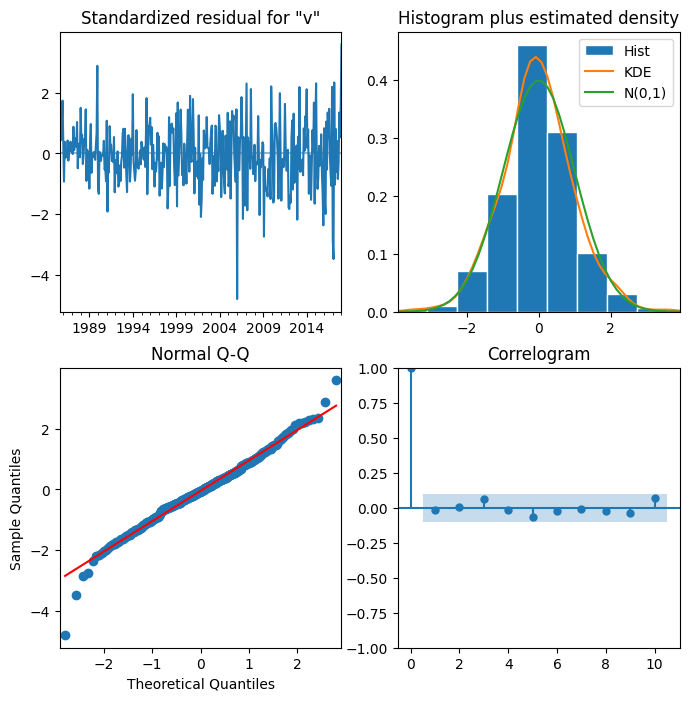

In [56]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

# SARIMA Prediction

In [57]:
# Now we will create a vector that will host the predictions
prediction = results.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

In [58]:
# Moreover, we also get the confidence intervals from the sarima prediction
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

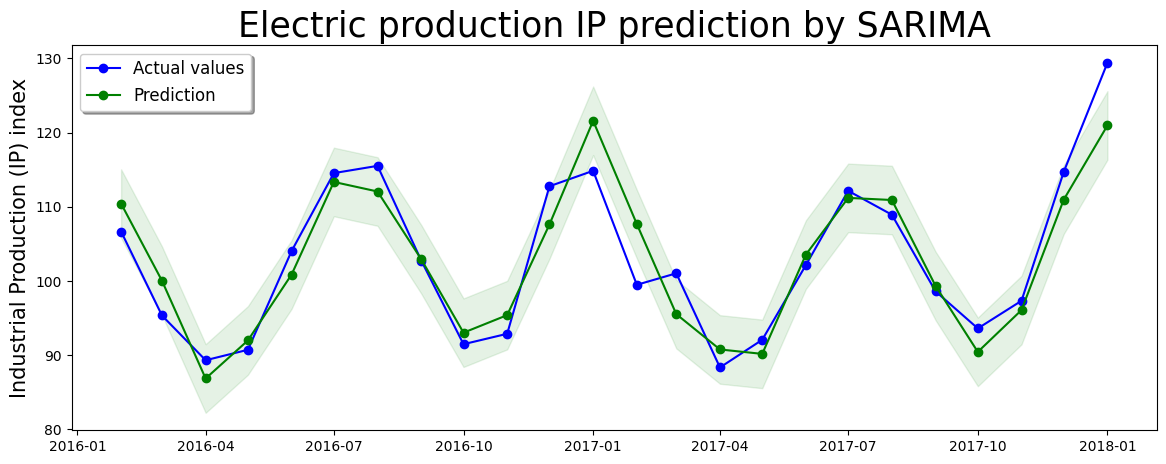

In [59]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by SARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [60]:
mape_sarima = mape(df.iloc[-24:,0],mean_prediction)
print(f"MAPE OF SARIMA MODEL : {mape_sarima:.2f} %")

MAPE OF SARIMA MODEL : 3.02 %


In [61]:
rmse_sarima = sqrt(mean_squared_error(df[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 3.87


# SARIMA Forecast

In [62]:
# Make ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

In [63]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

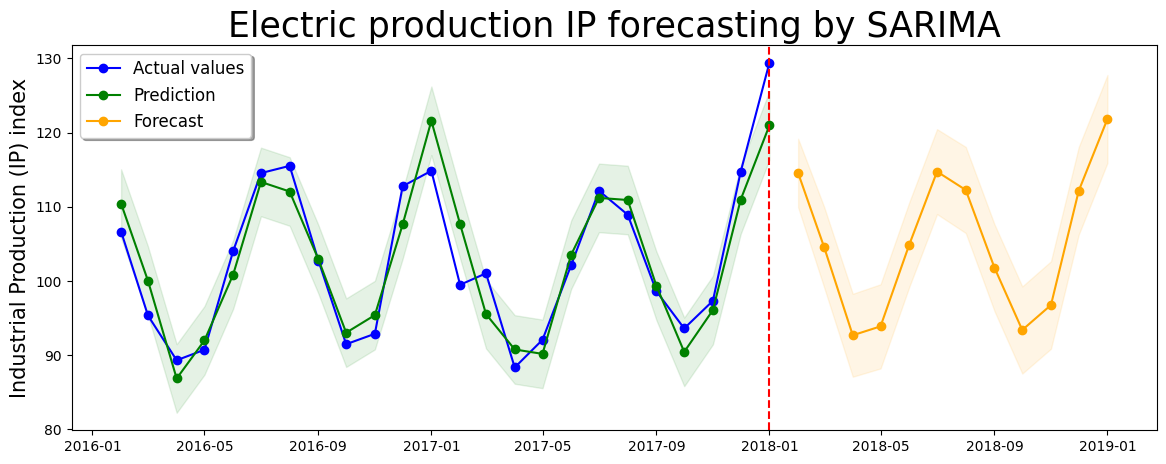

In [64]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by SARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [66]:
df_sarimax = mean_prediction.append(mean_forecast)

AttributeError: 'Series' object has no attribute 'append'

In [69]:
df_sarimax = pd.concat([mean_prediction, mean_forecast])

# Results Sumamry

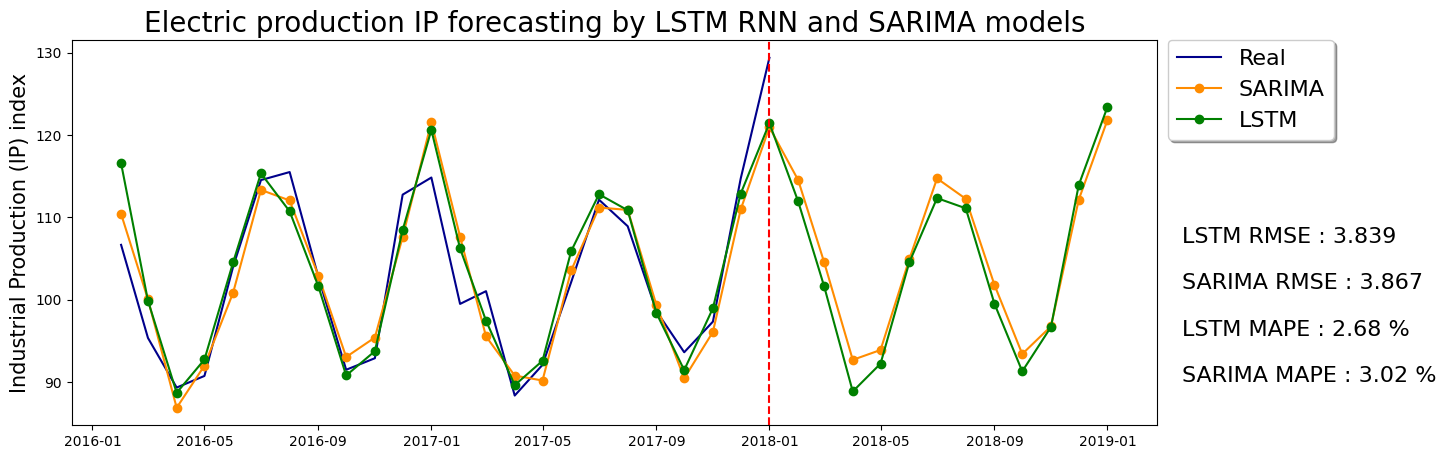

In [71]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by LSTM RNN and SARIMA models", fontsize=20)
plt.plot(df[-24:].index,df[-24:].values, color='darkblue', label='Real')
plt.plot(df_sarimax.index, df_sarimax.values, color='darkorange', label='SARIMA', marker='o')
plt.plot(df_full.index, df_full['prediction'].values, color='green',label='LSTM', marker='o')
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1, 1.03),fontsize=16,fancybox=True, shadow=True, frameon=True)
text = 'LSTM RMSE : {:.3f}\n\nSARIMA RMSE : {:.3f}\n\nLSTM MAPE : {:.2f} %\n\nSARIMA MAPE : {:.2f} %'.format(rmse,rmse_sarima,mape_lstm,mape_sarima)
plt.text(mean_forecast.index[-1] + pd.DateOffset(days=80),90,text, fontsize=16)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()